[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Examples 4.34 and 4.41

Analysis of hourly precipitation data from 2015 and 2016 in Corvallis, Oregon, using Markov chains\
Topics: Markov chains, stationarity

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from numpy import linalg as LA

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

file_name_precipitation_2015 = "../data/weather/precipitation_2015.npy"
file_name_precipitation_2016 = "../data/weather/precipitation_2016.npy"

precipitation_matrix_2015 = np.load(file_name_precipitation_2015)
precipitation_matrix_2016 = np.load(file_name_precipitation_2016)

file_name_list = np.load('../data/weather/weather_station_names.npy')

In [3]:
station = 99
print(process_name(file_name_list[station+1]))

def remove_faulty_measurements(data,verbose):
    min_val = -100 
    median = np.median(data[data > min_val])
    data[data < min_val] = median
    return data

# We encode precipitation as 1 and no precipitation as 0
verbose = False
precipitation_aux_2015 = remove_faulty_measurements(precipitation_matrix_2015[:,station],verbose)
precipitation_2015 = np.zeros(len(precipitation_aux_2015))
precipitation_2015[precipitation_aux_2015 > 0] = 1
precipitation_aux_2016 = remove_faulty_measurements(precipitation_matrix_2016[:,station],verbose)
precipitation_2016 = np.zeros(len(precipitation_aux_2016))
precipitation_2016[precipitation_aux_2016 > 0] = 1

Corvallis, OR


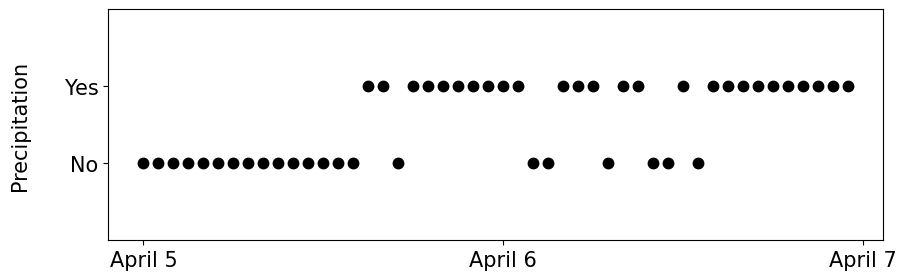

In [4]:
plt.figure(figsize=(10,3))
days_times_hours =24 * (31 + 28 +31+5) - 24
xtick_labels = ['April 5', 'April 6','April 7','Apr 8','Apr 9','Apr 10','Apr 11']
xtick_vals = days_times_hours + 24*np.arange(1,7+1,1) - 24
vals = days_times_hours + np.arange(0,24*(1+1),1)
plt.xticks(xtick_vals, xtick_labels,fontsize=font_size_ticks)
plt.plot(vals,precipitation_2015[vals],".",ms=15,color="black",lw=3,label="Second principal component")
plt.yticks([0,1],["No","Yes"],fontsize=font_size_ticks)
plt.ylabel("Precipitation",fontsize=font_size,labelpad=25)
plt.ylim([-1,2]);

In [5]:
p_precipitation = np.sum(precipitation_2015) / len(precipitation_2015)
print("Probability of precipitation in 2015: "+str(round(p_precipitation,3)))

count_matrix = np.zeros((2,2))
for ind in range(len(precipitation_2015)-1):
    count_matrix[int(precipitation_2015[ind+1]),int(precipitation_2015[ind])] += 1
transition_matrix = count_matrix/count_matrix.sum(axis=0, keepdims=True)
print("Transition matrix")
print(transition_matrix)

count_matrix_2 = np.zeros((2,2,2))
for ind in range(len(precipitation_2015)-2):
    count_matrix_2[int(precipitation_2015[ind]),int(precipitation_2015[ind+2]),int(precipitation_2015[ind+1])] += 1
transition_matrix_2 = count_matrix_2/count_matrix_2.sum(axis=1, keepdims=True)
print("Two steps")
print("Transition matrix (no precipitation two hours before)")
print(transition_matrix_2[0,:,:])
print("Transition matrix (precipitation two hours before)")
print(transition_matrix_2[1,:,:])

Probability of precipitation in 2015: 0.113
Transition matrix
[[0.96  0.312]
 [0.04  0.688]]
Two steps
Transition matrix (no precipitation two hours before)
[[0.971 0.494]
 [0.029 0.506]]
Transition matrix (precipitation two hours before)
[[0.706 0.23 ]
 [0.294 0.77 ]]


In [6]:
# Matrix containing the true/false positives and true/false positives for 2016, if we model the precipitation in 2015 as independent
confusion_matrix_iid_model = np.zeros((2,2)) 
# Matrix containing the true/false positives and true/false positives for 2016, if we model the precipitation in 2015 as a time-homogeneous 
# Markov chain
confusion_matrix_markov_model = np.zeros((2,2))

# No precipitation is more likely than precipitation
iid_estimate = 0 
for ind in np.arange(1,len(precipitation_2016)):
    confusion_matrix_iid_model[iid_estimate,int(precipitation_2016[ind])] += 1
    # Precipitation is more likely after precipitation, and no precipitation is more likely after no precipitation
    markov_model_estimate = int(precipitation_2016[ind-1]) 
    confusion_matrix_markov_model[markov_model_estimate,int(precipitation_2016[ind])] += 1

print("Confusion matrix for the iid model")
print(confusion_matrix_iid_model)
accuracy_iid = (confusion_matrix_iid_model[0][0] + confusion_matrix_iid_model[1][1])/np.sum(confusion_matrix_iid_model)
print("Accuracy: ", round(accuracy_iid,3))

print("Confusion matrix for the Markov chain model")
print(confusion_matrix_markov_model)
accuracy_markov = (confusion_matrix_markov_model[0][0] + confusion_matrix_markov_model[1][1])/np.sum(confusion_matrix_markov_model)
print("Accuracy: ", round(accuracy_markov,3))

Confusion matrix for the iid model
[[7328. 1455.]
 [   0.    0.]]
Accuracy:  0.834
Confusion matrix for the Markov chain model
[[6774.  554.]
 [ 554.  901.]]
Accuracy:  0.874


In [7]:
eigenvalues, eigenvectors = LA.eig(transition_matrix)

print("Eigenvalues of the transition matrix",eigenvalues)
aux_sum = np.sum(eigenvectors[:,0])
print("Q")
Q = eigenvectors/aux_sum
print(Q)
print("Qinv")
print(LA.inv(Q))
print("Stationary distribution corresponding to eigenvalue 1")
print(Q[:,0])
print("Result of applying the transition matrix to the stationary distribution")
print(transition_matrix @ Q[:,0])

Eigenvalues of the transition matrix [1.    0.648]
Q
[[ 0.887 -0.632]
 [ 0.113  0.632]]
Qinv
[[ 1.     1.   ]
 [-0.179  1.403]]
Stationary distribution corresponding to eigenvalue 1
[0.887 0.113]
Result of applying the transition matrix to the stationary distribution
[0.887 0.113]
